In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [20]:
def evaluate_model(model, X_train, y_train, X_test, y_test, class_names=['Ia','Ibc','II']):
  print("The training set:")
  y_train_pred = model.predict(X_train)
  print("\n Validation accuracy: ", accuracy_score(y_train, y_train_pred))
  print("\n Classification report:\n ",classification_report(y_train, y_train_pred))
  print("\n Confusion matrix:\n", confusion_matrix(y_train, y_train_pred))

  print("\nThe test set:")
  y_test_pred = model.predict(X_test)
  print("\n Validation accuracy: ", accuracy_score(y_test, y_test_pred))
  print("\n Classification report:\n ",classification_report(y_test, y_test_pred))
  print("\n Confusion matrix: \n", confusion_matrix(y_test, y_test_pred))

  # ---- ROC Curve ----
  classes = np.unique(y_test)
  n_classes = len(classes)
  y_test_bin = label_binarize(y_test, classes=classes)
  y_score = model.predict_proba(X_test)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(7,6))
  colors = plt.cm.get_cmap('Set1', n_classes)
  for i in range(n_classes):
    label = f"Class {i}" if class_names is None else class_names[i]
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')

  plt.plot([0,1], [0,1], 'k--', lw=1)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC Curve')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

In [4]:
# load data
Ia = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/ML_master_table_TypeIa.csv')
Ibc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/ML_master_table_TypeIbc.csv')
II = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/ML_master_table_TypeII.csv')

Attempt 1: Original data

In [14]:
data = pd.concat([Ia, Ibc, II], ignore_index=True)
data = data.dropna()
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

skip = {'sn_name', 'sn_type', 'band'}
feature_cols = [c for c in data.columns if c not in skip]

# features
X = data[feature_cols]

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

X = X.clip(lower=lower, upper=upper, axis=1)

# labels
y = data['sn_type']
print("Unique mapped labels:", y.unique())

name_Ia = ['Ia','IaQ','Ia_Pec']
name_II = ['II','II_P','IIP','IIQ','II_L','II_Pec']

y = y.apply(lambda v: 0 if v in name_Ia else (2 if v in name_II else 1))

# count examples in classes
pd.Series(y).value_counts()

Unique mapped labels: ['II' 'Ia' 'Ib_c' 'Ib' 'Ia_Pec' 'IaQ' 'Ic' 'Ic_Pec' 'II_P' 'IIQ' 'IIP'
 'Ib-pec' 'II_L' 'IcQ' 'II_Pec' 'Ic/Ic-BL']


,count
sn_type,
0,12590
2,12447
1,600


In [15]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
    shuffle=True
)

scaler = RobustScaler()
X_train1 = scaler.fit_transform(X_train1)
X_test1 = scaler.transform(X_test1)

In [23]:
model1 = MLPClassifier(
    hidden_layer_sizes=(128,64,64),
    activation='relu',
    alpha=0.001,
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    shuffle=True,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1
)

model1.fit(X_train1,y_train1)

Iteration 1, loss = 0.65090640
Validation score: 0.720137
Iteration 2, loss = 0.62589919
Validation score: 0.728425
Iteration 3, loss = 0.61794042
Validation score: 0.733788
Iteration 4, loss = 0.61274147
Validation score: 0.732813
Iteration 5, loss = 0.61142206
Validation score: 0.728425
Iteration 6, loss = 0.60613789
Validation score: 0.742077
Iteration 7, loss = 0.60626615
Validation score: 0.731351
Iteration 8, loss = 0.60413306
Validation score: 0.744027
Iteration 9, loss = 0.60228709
Validation score: 0.743540
Iteration 10, loss = 0.60115750
Validation score: 0.743540
Iteration 11, loss = 0.59961727
Validation score: 0.730375
Iteration 12, loss = 0.59952697
Validation score: 0.734276
Iteration 13, loss = 0.59945613
Validation score: 0.730375
Iteration 14, loss = 0.59881211
Validation score: 0.745002
Iteration 15, loss = 0.59707268
Validation score: 0.745978
Iteration 16, loss = 0.59700247
Validation score: 0.748415
Iteration 17, loss = 0.59544548
Validation score: 0.739639
Iterat

MLPClassifier(alpha=0.001, batch_size=32, early_stopping=True,
              hidden_layer_sizes=(128, 64, 64), learning_rate='adaptive',
              max_iter=500, verbose=True)

The training set:

 Validation accuracy:  0.737334828611829

 Classification report:
                precision    recall  f1-score   support

           0       0.72      0.78      0.75     10072
           1       1.00      0.01      0.02       480
           2       0.76      0.73      0.74      9957

    accuracy                           0.74     20509
   macro avg       0.83      0.51      0.50     20509
weighted avg       0.74      0.74      0.73     20509


 Confusion matrix:
 [[7859    0 2213]
 [ 344    5  131]
 [2699    0 7258]]

The test set:

 Validation accuracy:  0.7425897035881436

 Classification report:
                precision    recall  f1-score   support

           0       0.73      0.78      0.75      2518
           1       1.00      0.01      0.02       120
           2       0.76      0.74      0.75      2490

    accuracy                           0.74      5128
   macro avg       0.83      0.51      0.51      5128
weighted avg       0.75      0.74      0.73  

/tmp/ipython-input-2300112926.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


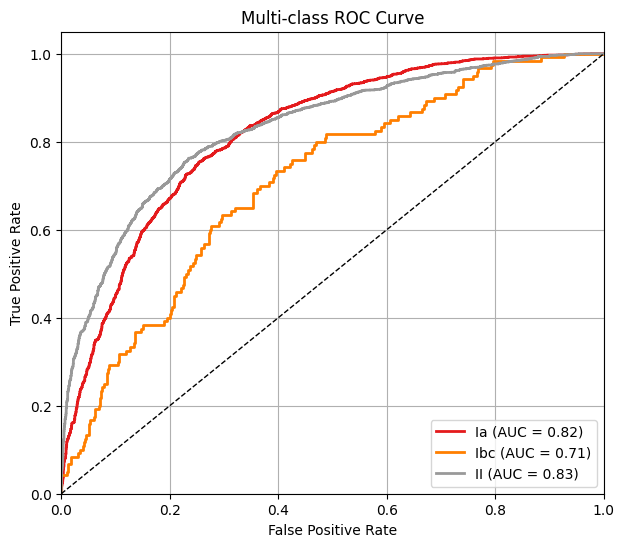

In [24]:
evaluate_model(model1, X_train1, y_train1, X_test1, y_test1)

Attempt 2: Downsampling

In [33]:
Ia_down = Ia.sample(1000)
II_down = II.sample(1000)

data_down = pd.concat([Ia_down, Ibc, II_down], ignore_index=True)
data_down = data_down.dropna()
data_down = data_down.sample(frac=1, random_state=42).reset_index(drop=True)

# features
X_down = data_down[feature_cols]

Q1 = X_down.quantile(0.25)
Q3 = X_down.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

X_down = X_down.clip(lower=lower, upper=upper, axis=1)

# labels
y_down = data_down['sn_type']
print("Unique mapped labels:", y_down.unique())

y_down = y_down.apply(lambda v: 0 if v in name_Ia else (2 if v in name_II else 1))

# count examples in classes
pd.Series(y_down).value_counts()

Unique mapped labels: ['Ib_c' 'II' 'Ia' 'Ib' 'Ic' 'II_P' 'Ib-pec' 'IcQ' 'Ia_Pec' 'IIQ' 'IaQ'
 'Ic_Pec' 'II_Pec' 'Ic/Ic-BL' 'IIP']


,count
sn_type,
0,1000
2,991
1,600


In [34]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_down, y_down,
    test_size=0.2,
    random_state=42,
    stratify=y_down,
    shuffle=True
)

scaler = RobustScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [57]:
model2 = MLPClassifier(
    hidden_layer_sizes=(32,32),
    activation='relu',
    alpha=0.001,
    batch_size=16,
    learning_rate='adaptive',
    max_iter=500,
    shuffle=True,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1
)

model2.fit(X_train2,y_train2)

Iteration 1, loss = 1.01986713
Validation score: 0.552885
Iteration 2, loss = 0.95782112
Validation score: 0.557692
Iteration 3, loss = 0.93768950
Validation score: 0.581731
Iteration 4, loss = 0.92708254
Validation score: 0.572115
Iteration 5, loss = 0.91626609
Validation score: 0.576923
Iteration 6, loss = 0.91015775
Validation score: 0.596154
Iteration 7, loss = 0.90324403
Validation score: 0.600962
Iteration 8, loss = 0.89848688
Validation score: 0.625000
Iteration 9, loss = 0.89513785
Validation score: 0.557692
Iteration 10, loss = 0.89328030
Validation score: 0.519231
Iteration 11, loss = 0.89086092
Validation score: 0.519231
Iteration 12, loss = 0.88690192
Validation score: 0.576923
Iteration 13, loss = 0.88573243
Validation score: 0.557692
Iteration 14, loss = 0.88423875
Validation score: 0.620192
Iteration 15, loss = 0.88284622
Validation score: 0.514423
Iteration 16, loss = 0.88249003
Validation score: 0.557692
Iteration 17, loss = 0.87639425
Validation score: 0.557692
Iterat

MLPClassifier(alpha=0.001, batch_size=16, early_stopping=True,
              hidden_layer_sizes=(32, 32), learning_rate='adaptive',
              max_iter=500, verbose=True)

The training set:

 Validation accuracy:  0.5916988416988417

 Classification report:
                precision    recall  f1-score   support

           0       0.53      0.77      0.63       800
           1       0.53      0.25      0.34       480
           2       0.71      0.62      0.66       792

    accuracy                           0.59      2072
   macro avg       0.59      0.55      0.54      2072
weighted avg       0.60      0.59      0.57      2072


 Confusion matrix:
 [[617  51 132]
 [292 121  67]
 [247  57 488]]

The test set:

 Validation accuracy:  0.6069364161849711

 Classification report:
                precision    recall  f1-score   support

           0       0.56      0.81      0.66       200
           1       0.51      0.18      0.27       120
           2       0.70      0.66      0.68       199

    accuracy                           0.61       519
   macro avg       0.59      0.55      0.54       519
weighted avg       0.60      0.61      0.58       519

/tmp/ipython-input-2300112926.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


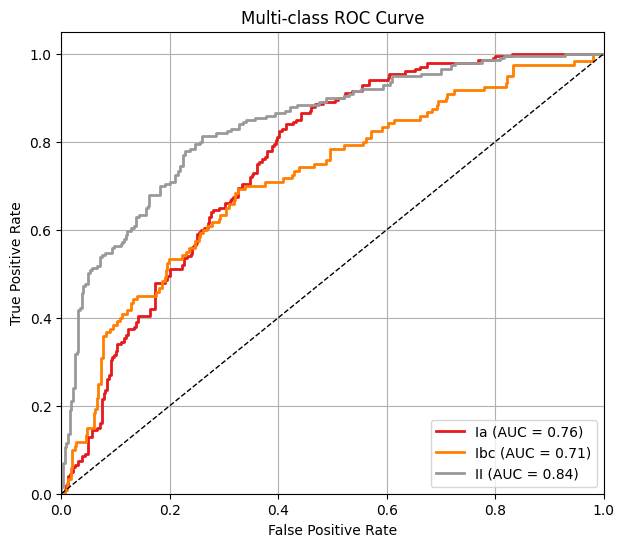

In [58]:
evaluate_model(model2, X_train2, y_train2, X_test2, y_test2)